# Q2. iLQR $[80 pts]$

Let the state vector $\mathbf{x}$ and the input vector $\mathbf{u}$ is as
$$\mathbf{x}=\begin{bmatrix}x_1\\x_2\\ \theta\end{bmatrix},  \mathbf{u}=\begin{bmatrix}u_1\\u_2\end{bmatrix}$$

Then, the state space equation of the simple car is as follows:

$$\dot{x_1}=u_1\cos\theta$$
$$\dot{x_2}=u_1\sin\theta$$
$$\dot{\theta}=u_2$$
with the initial state $x=0$, $y=0$, $\theta=0$ and the instantaneous cost function
$$c(\mathbf{x}, \mathbf{u})=0.025||\mathbf{u}||^{2}$$
and the final cost function
$$c_f(\mathbf{x}, \mathbf{u})=(x_1-2)^{2}+(x_2-1.5)^{2}$$

- Complete the forward part of the iLQR algorithm [15pts]

- Complete the state space equation of the simple car where $T=200$, $dt=0.05$. [15pts]

- A brief report(in ipynb using Markdown cell type or pdf form with result screen shot): Explain in detail (through an equation) the process of solving the simple car model with iLQR by referring to the forward and backward model of LQR. Explain how each process was working and why it is needed. [50pts]

Ref) Optimal Control to RL (UofT CSC26t21) Lecture Note

In [1]:
from autograd import grad, jacobian
import autograd.numpy as np
from matplotlib import pyplot as plt

In [2]:
class ILqr:
    
    def __init__(self, dynamics, running_cost, final_cost, state_dim, horizon):
        
        self.f = dynamics
        self.horizon = horizon
        
        self.f_x = jacobian(self.f,0)
        self.f_u = jacobian(self.f,1)
        
        self.f_xx = jacobian(self.f_x, 0)
        self.f_uu = jacobian(self.f_u, 1)
        self.f_ux = jacobian(self.f_u, 0)

        self.lf = final_cost
        self.lf_x = grad(self.lf,0)
        self.lf_xx = jacobian(self.lf_x,0)
        
        
        self.v = [0.0 for _ in range(horizon+1)]
        self.v_x = [np.zeros(state_dim) for _ in range(horizon+1)]
        self.v_xx = [np.zeros((state_dim,state_dim)) for _ in range(horizon+1)]
        
        self.l = running_cost
        self.l_x = grad(self.l,0)
        self.l_u = grad(self.l,1)
        
        self.l_xx = jacobian(self.l_x,0)
        self.l_uu = jacobian(self.l_u,1)
        self.l_ux = jacobian(self.l_u,0)
        
    def backward(self, x_seq, u_seq):
        
        self.v[-1] = self.lf(x_seq[-1],u_seq[-1])
        self.v_x[-1] = self.lf_x(x_seq[-1],u_seq[-1])
        self.v_xx[-1] = self.lf_xx(x_seq[-1],u_seq[-1]) 
        
        k_seq = [] 
        kk_seq = []
        
        for t in range(self.horizon-1,-1,-1):
            
            x = x_seq[t]
            u = u_seq[t]
            
            # Evaluate expansion coeeficients
            f_x_t = self.f_x(x,u)
            f_u_t = self.f_u(x,u)
            
            f_xx_t = self.f_xx(x,u)
            f_uu_t = self.f_uu(x,u)
            f_ux_t = self.f_ux(x,u)
            
            l_x_t = self.l_x(x,u)
            l_u_t = self.l_u(x,u)
            
            l_xx_t = self.l_xx(x,u)
            l_uu_t = self.l_uu(x,u)
            l_ux_t = self.l_ux(x,u)
            
            v_x_t = self.v_x[t+1]
            v_xx_t = self.v_xx[t+1]
            
            q_x = l_x_t + np.matmul(f_x_t.T,v_x_t)
            q_u = l_u_t + np.matmul(f_u_t.T,v_x_t)
            
            q_xx = l_xx_t + np.matmul(np.matmul(f_x_t.T,v_xx_t),f_x_t) + (v_x_t.reshape(-1,1,1)*f_xx_t).sum(axis=0)
            
            q_uu = l_uu_t + np.matmul(np.matmul(f_u_t.T,v_xx_t),f_u_t) + (v_x_t.reshape(-1,1,1)*f_uu_t).sum(axis=0)
            
            q_ux = l_ux_t + ((f_u_t.T).dot(v_xx_t)).dot(f_x_t) + (v_x_t.reshape(-1,1,1)*f_ux_t).sum(axis=0)
        
            q_uu_inv = np.linalg.inv(q_uu+1e-9*np.eye(q_uu.shape[0]))
            
            k = -q_uu_inv.dot(q_u) # open loop gain
            kk = -q_uu_inv.dot(q_ux) # feedback gain
            
            self.v[t] += 0.5*(k.T.dot(q_uu)).dot(k) + k.T.dot(q_u)#q_u.dot(k)
            self.v_x[t] = q_x + (kk.T.dot(q_uu)).dot(k) + kk.T.dot(q_u) + q_ux.T.dot(k)#q_u.dot(kk)
            self.v_xx[t] = q_xx + (kk.T.dot(q_uu)).dot(kk) + kk.T.dot(q_ux) + q_ux.T.dot(kk)#q_ux.T.dot(kk)
            
            k_seq.append(k)
            kk_seq.append(kk)
        
        k_seq.reverse()
        kk_seq.reverse()
        
        return k_seq,kk_seq
    
    def forward(self, x_seq, u_seq, k_seq, kk_seq):
        
        x_seq_hat = np.array(x_seq)
        u_seq_hat = np.array(u_seq)
        
        
        for t in range(len(u_seq)):
            ##########################################
            # Task1: fill your code here
            # Complete the forward part of iLQR
            # Update 'control' through k_seq and kk_seq, x_seq, x_seq_hat.
            ##########################################
            # u_hat_t - u_t = K_t (x_hat_t - x_t) + k_t
            control = (1)*(kk_seq[t]@(x_seq_hat[t] - x_seq[t]) + k_seq[t])  # du

            u_seq_hat[t] = np.clip(u_seq[t] + control,-0.5,0.5)
            x_seq_hat[t+1] = self.f(x_seq_hat[t], u_seq_hat[t])  # real non-linear dynamics
            
        return x_seq_hat, u_seq_hat

In [3]:
def update(x,u):
    dt = 0.05
    ##########################################
    # Task2: fill your code here
    # Complete the state space equation of the simple car
    # Discretize the state space equation and approximate linear function
    # Update the state space equation x=(x0, x1, x2)
    ##########################################
    x0 = x[0] + u[0] * np.cos(x[2]) * dt
    x1 = x[1] + u[0] * np.sin(x[2]) * dt
    x2 = x[2] + u[1] * dt
    return np.array((x0,x1,x2))  # next state

In [4]:
ilqr = ILqr(lambda x, u: update(x, u), lambda x, u: 0.025*np.sum(np.square(u)), lambda x, u: 1*np.square(x[0]-2) + 1*np.square(x[1]-1.5), 3, horizon=200)

In [5]:
u_seq = [0.3*np.random.randn((2)) for _ in range(ilqr.horizon)]
x_seq = [np.zeros((3))]

for t in range(ilqr.horizon):
    x_seq.append(update(x_seq[-1], u_seq[t]))
x_seq = np.array(x_seq)
u_seq = np.array(u_seq)

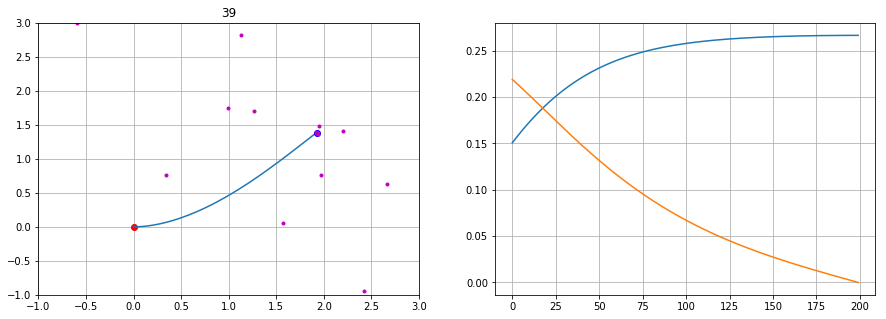

In [6]:
from IPython import display
reps = 40

goals = []
plt.figure(figsize=(15,5))
for j in range(reps):
    k_seq, kk_seq = ilqr.backward(x_seq, u_seq)
    x_seq, u_seq = ilqr.forward(x_seq, u_seq, k_seq, kk_seq)
    
    goals.append(x_seq[-1,:])
    plt.cla()
    plt.subplot(1,2,1)
    plt.cla()
    plt.plot(x_seq[0,0],x_seq[0,1],'ro')
    plt.plot(x_seq[:,0],x_seq[:,1])
    plt.plot(x_seq[-1,0],x_seq[-1,1],'bo')
    plt.plot(np.array(goals)[:,0],np.array(goals)[:,1],'m.')
    plt.xlim(-1,3)
    plt.ylim(-1,3)
    plt.grid()
    plt.title(j)

    plt.subplot(1,2,2)
    plt.cla()
    plt.plot(u_seq)
    plt.grid()

    display.clear_output(wait=True)
    display.display(plt.gcf())

## Task3: A brief report [50pts]

A brief report(in ipynb using Markdown cell type or pdf form with result screen shot)

Explain in detail (through an equation) the process of solving the simple car model with iLQR by referring to the forward and backward model of LQR. Explain how each process was working and why it is needed.

#### Results:

처음에 랜덤하게 u를 초기화하였으나, iteration 반복에 따라 다음과 같은 결과를 얻었다. 결과를 보면 final cost에 의해 (2, 1.5)에 가깝게 도달한 것을 알 수 있다. 또한 iteration 반복 중에 아래 결과에 도달하면 iteration 반복해도 결과가 변하지 않는 것을 관찰하였다.

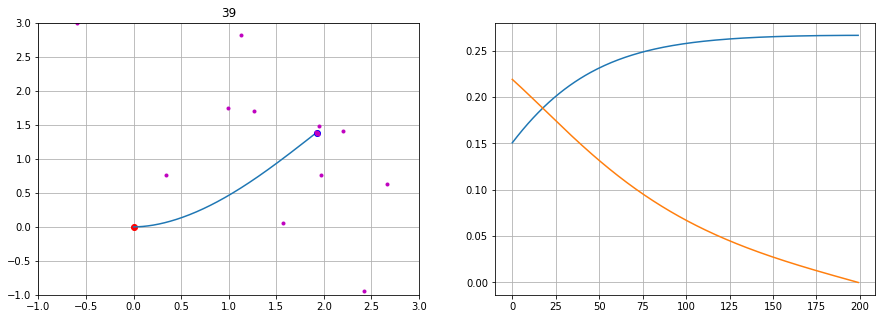

#### Backward Process

각 iteration에서 이루어지는 backward process를 살펴보면 다음과 같다.
- linearized dynamics
$f(\hat{x}, \hat{u}) \approx f(x, u) + \frac{\partial f}{\partial x}(x, u)\delta x + \frac{\partial f}{\partial u}(x, u)\delta u$ 
- 기준이 되는 x_seq, u_seq을 사용하여 terminal value 계산 ($V(T) = c_f(x(T))$, 코드에서는 lf, 강의자료와 $(x, u)$, $(\hat{x}, \hat{u})$ 역할 반대)
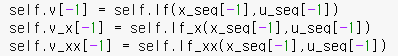
 $V(T) = c_f(x(T))$

- 코드와 동일한 표현을 위해 instantaneous cost $c$ 대신 $l$ 사용
$Q = \frac{\partial V}{\partial x} f(x, u) + l(x, u)$
    - $Q_x = \frac{\partial Q}{\partial x} = \frac{\partial l}{\partial x} + \frac{\partial V}{\partial x} \frac{\partial f}{\partial x}$
    - $Q_u = \frac{\partial l}{\partial u} + \frac{\partial V}{\partial x} \frac{\partial f}{\partial u}$
    - $Q_{xx} = \frac{\partial^2 l}{\partial x^2} +  \frac{\partial^2 V}{\partial x^2} \frac{\partial f}{\partial x} +  \frac{\partial V}{\partial x} \frac{\partial^2 f}{\partial x^2} $
    - $Q_{ux} = \frac{\partial^2 l}{\partial x \partial u} +  \frac{\partial f}{\partial u} \frac{\partial V}{\partial x} \frac{\partial f}{\partial x} +  \frac{\partial V}{\partial x} \frac{\partial^2 f}{\partial x \partial u} $
    - $Q_{uu} = \frac{\partial^2 l}{\partial u^2} + \frac{\partial f}{\partial u} \frac{\partial V}{\partial x} \frac{\partial f}{\partial x} +  \frac{\partial V}{\partial x} \frac{\partial^2 f}{\partial u^2} $

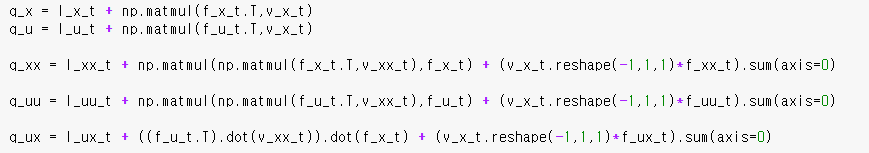

- Tayler expension
$Q + \delta Q \approx Q(x, u) + Q_x \delta x + Q_u + \delta u + \frac{1}{2} \delta x^T Q_{xx} \delta x + \frac{1}{2} \delta u^T Q_{uu} \delta u + \frac{1}{2} \delta x^T Q_{xu} \delta u + \frac{1}{2} \delta u^T Q_{ux} \delta x$
- $\delta Q$ 최소화하도록 $\delta u$ 결정 ($u$에 대한 미분 = 0)
$\frac{\partial \delta Q}{\partial u} = Q_u + \frac{1}{2} Q_{ux} \delta x + Q_{uu} \delta u = 0$
- $\delta u^* = -Q_{uu}^{-1}(Q_ux \delta x + Q_u)$
- $K = -Q_{uu}^{-1}Q_ux$, $k = -Q_{uu}^{-1}Q_u$
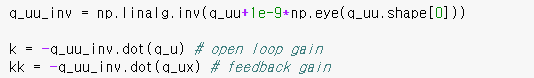

#### Forward Process

- Backward에서 결정된 $k, K$와 $\delta x(0)$ 사용하여 $\delta u$(controls) 계산
$\delta u(t) = K(t) \delta x(t) + k(t)$
- $\hat{u}(t) = u(t) + \delta u(t)$
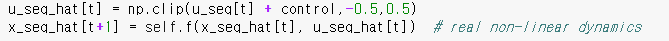
- 계산된 $\hat{u}(t)$를 non-linear dynamic에 넣어 $\hat{x}(t+1)$ 계산
- $\hat{x}(t+1) = f(\hat{x}(t), \hat{u}(t))$
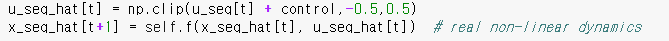

#### Iteration

- iteration 반복하면서 현재 $(\{x\}_t, \{u\}_t)_j$를 사용하여 backward process를 통해 $K, k$ 계산
- 계산된 $K, k$와 $(\{x\}_t, \{u\}_t)$를 사용하여 forward 를 통해 다음 iteration에 사용할 $(\{x\}_t, \{u\}_t)_{j+1}$ 계산
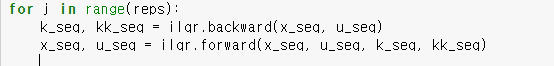